In [1]:
import numpy as np
from copy import copy
import random
import graphviz
from IPython.display import display

In [2]:
class Node:
    def __init__(self):
        self.parent = None
        self.childs = []
        self.strats = []
        self.id = None
        self.prices = None
        self.player = None
        self.paths = []
        
    def is_leaf(self):
        return len(self.childs) == 0
    
    def __repr__(self):
        return f'Node({self.id}; {self.paths})'

## Построение дерева

In [3]:
def generate_heights(height, count):
    return np.append(np.random.randint(0, height, size=count-1), height)[np.random.choice(count, count, replace=False)]

def generate_subtree(root, height, players_count, strat_count, random_limits, turn, id_container):
    root.player = turn
    if height <= 1:
        return
    
    heights = generate_heights(height - 1, strat_count[turn])
    
    for i in range(strat_count[turn]):
        id_container['id'] += 1
        child = Node()
        child.id = id_container['id']
        child.parent = root
        
        generate_subtree(child, heights[i], players_count, strat_count, random_limits, (turn + 1) % players_count, id_container)
        
        root.childs.append(child)
        

def generate_tree(height, players_count, strat_count, random_limits):
    id_container = {'id' : 0}
    
    root = Node()
    root.id = id_container['id']
    root.player = 0
    
    heights = generate_heights(height, players_count)
    
    for i in range(players_count):
        id_container['id'] += 1
        child = Node()
        child.id = id_container['id']
        child.parent = root
        generate_subtree(child, heights[i], players_count, strat_count, random_limits, i, id_container)
        
        root.childs.append(child)
        
    fill_leafes(get_leafes(root), players_count, random_limits)
    
    root.paths = [i for i in range(players_count)]
    
    return root

def get_leafes(root):
    if root.is_leaf():
        return [root]
    
    leafes = []
    
    for i in root.childs:
        leafes.extend(get_leafes(i))
        
    return leafes

def fill_leafes(leafes, players_count, random_limits):
    for leaf in leafes:
        leaf.strats = np.array([np.random.randint(random_limits[0], random_limits[1], players_count)])


## Поиск пути

In [4]:
def solve_tree(root, players_count):
    for child in root.childs:
        solve_subtree(child, players_count)
        root.strats = np.append(root.strats, child.strats)
        
    root.strats = root.strats.reshape(root.strats.shape[0] // players_count, players_count)
        
def solve_subtree(root, players_count):
    if root.is_leaf():
        return
        
    all_strats = []
    root.strats = np.array([])

    for child in root.childs:
        solve_subtree(child, players_count)
        
        all_strats.append(child.strats)
        
    maximum = -999999999999999
    
    for strats in all_strats:
        maximum = max(maximum, np.max(strats[:, root.player]))

    for id, strats in enumerate(all_strats):
        if maximum == np.max(strats[:, root.player]):
            root.strats = np.append(root.strats, strats)
            root.paths.append(id)
    
        
    root.strats = root.strats.reshape(root.strats.shape[0] // players_count, players_count)
    
def get_full_paths(root):
    if root.is_leaf():
        return [[root]]
    
    paths = []
    for id, child in enumerate(root.childs):
        if id in root.paths:
            path = [root]
            
            child_paths = get_full_paths(child)
            
            for child_path in child_paths:
                paths.append(path + child_path)
            
    return paths

def get_paths_meta(paths):
    meta = {}
    
    for id, path in enumerate(paths):
        for i in range(1, len(path)):
            edge = (path[i - 1].id, path[i].id)
            
            if edge not in meta.keys():
                meta[edge] = []
                
            meta[edge].append(id)
    
    for i in range(len(paths)):
        meta[i] = paths[i][-1].strats[0]
            
    return meta

## Вывод в DOT

In [9]:
COLORS = ['red', 'green', 'blue', 'orange', 'pink', 'greenyellow', 'magenta']
    
def generate_dot_strings(root, paths_meta = None):
    notes = []
    
    if root.parent is None:
        notes.append('digraph G {')
        notes.append('rankdir = LR')
        notes.append('_0[label="player; id\\n[costs]",color=orange]')
        strats = root.strats
        if strats is not None:
            strats = np.round(strats, 2)
            
        notes.append(f'{root.id}[label="{strats}"]')
    else:
        strats = root.strats
        if strats is not None:
            strats = np.round(strats, 2)
            
        label = ''
        if not root.is_leaf():
            label += f'{root.player + 1}; '
        label += f'{root.id}\\n{strats}'
        
        notes.append(f'{root.id}[label="{label}"]')
        
    for id, node in enumerate(root.childs):
        if paths_meta is not None and (root.id, node.id) in paths_meta.keys():
            for i in paths_meta[(root.id, node.id)]:
                color = COLORS[i]
                label = paths_meta[i]
                notes.append(f'{root.id} -> {node.id}[color={color},label=<<font color="{color}">{label}</font>>]')
        else:
            notes.append(f'{root.id} -> {node.id}')
        
        child_notes = generate_dot_strings(node, paths_meta)
        
        notes.extend(child_notes)
        
    if root.parent is None:
        notes.append('}')
        
    return notes

def diplay_tree(root):
    paths = get_full_paths(tree)
    meta = get_paths_meta(paths)
    display(graphviz.Source('\n'.join(generate_dot_strings(tree, meta))))

## Вариант 15

In [10]:
game_params = {
    'height' : 7,
    'players_count' : 2,
    'strat_count' : (3, 2),
    'random_limits' : (-10, 20)
}

In [19]:
tree = generate_tree(**game_params)
solve_tree(tree, game_params['players_count'])

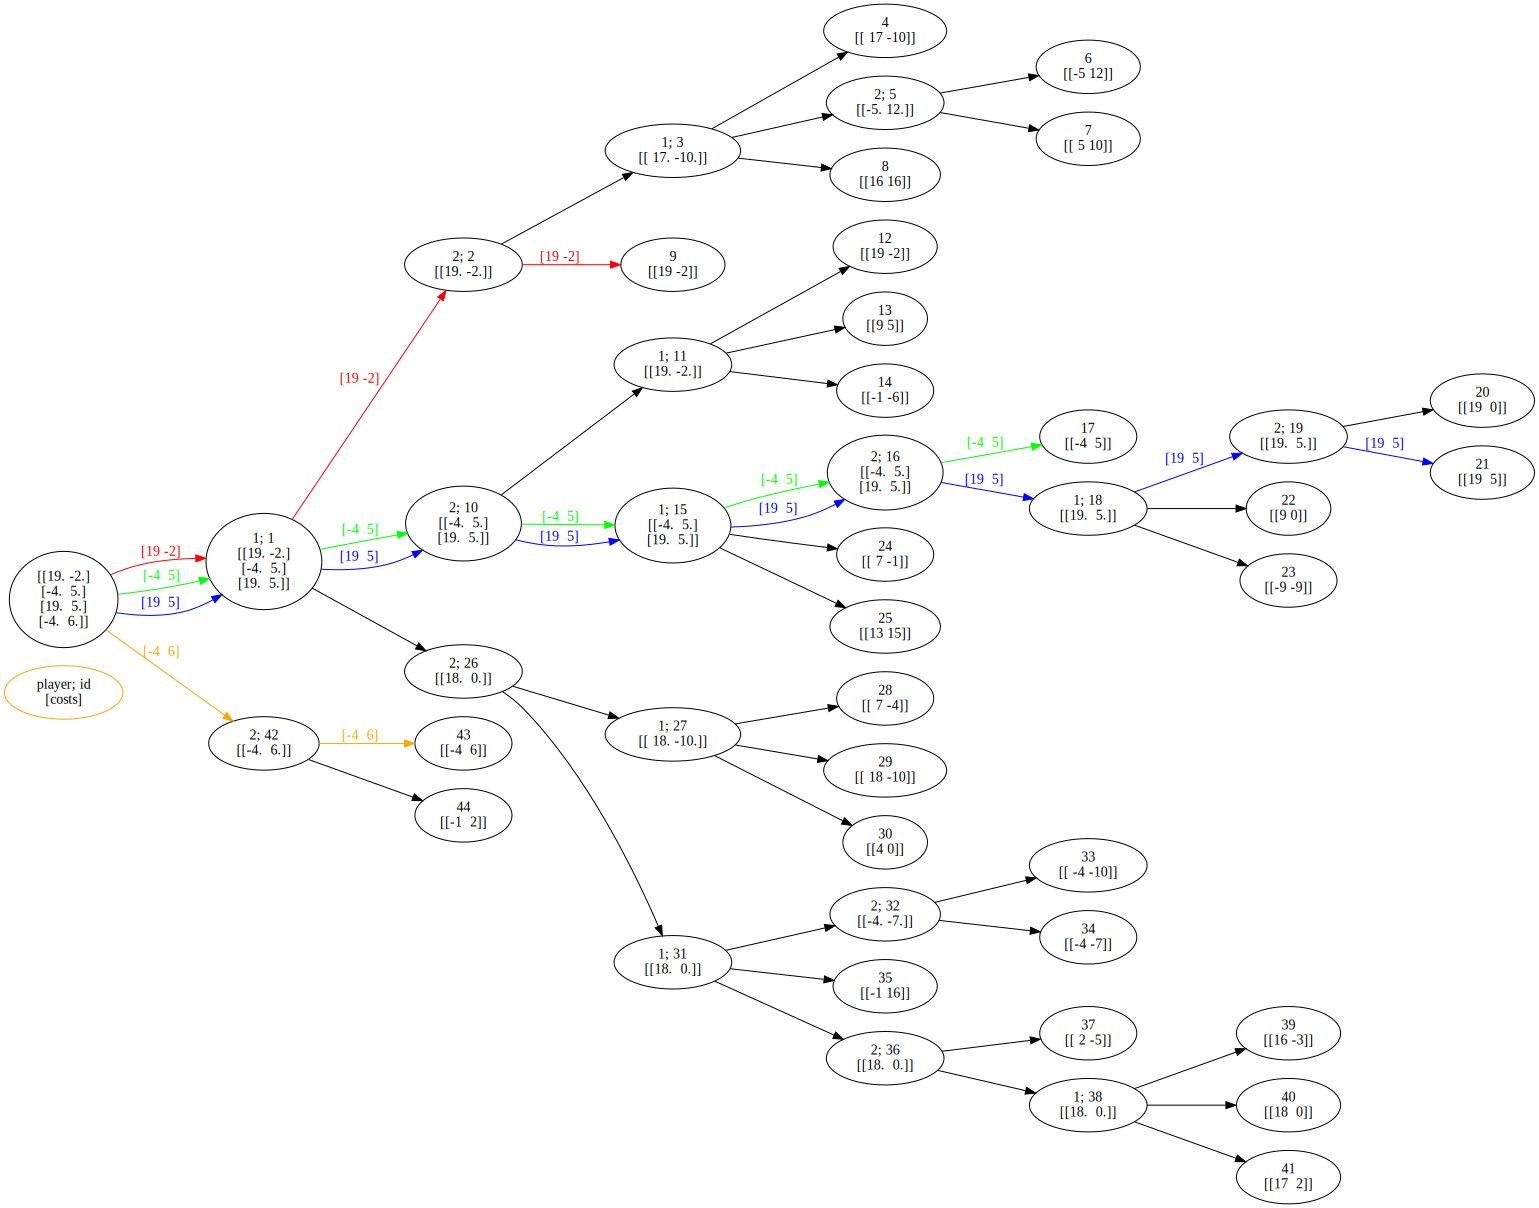

In [20]:
diplay_tree(tree)